In [144]:
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

import numpy as np
import matplotlib.pyplot as plt
import os

In [145]:
figdir = "./"
def savefig(fname):
    plt.savefig(os.path.join(figdir, fname))

$$
\mathcal{N}(\mathbf{y}\vert\mathbf{\mu},\mathbf{\Sigma})=\frac{1}{(2\pi)^{D/2}\vert\mathbf{\Sigma}\vert^{1/2}}\exp{\left\{-\frac{1}{2}(\mathbf{y}-\mathbf{\mu})^\intercal(\mathbf{\Sigma})^{-1}(\mathbf{y}-\mathbf{\mu})\right\}}
$$

In [146]:
def mvn2d(x, y, u, sigma):
    xx, yy = np.meshgrid(x, y)
    xy = np.c_[xx.ravel(), yy.ravel()]
    sigma_2d = np.eye(2) * sigma
    sigma_inv = np.linalg.inv(sigma_2d)
    z = np.dot((xy - u), sigma_inv)
    z = np.sum(z * (xy - u), axis=1) # to avoid memory overflow
    z = np.exp(-0.5 * z)
    z = z / (2 * np.pi * np.linalg.det(sigma) ** 0.5)
    return z.reshape(xx.shape)

## Make data

AB are the last two digits of your student number.
For example, if your student number is 170201003 then AB is 03 (A = 0, B = 3).

If any digit is 0, please add +1. In the example above, A will become 1.

Please fill A and in the code below as follows.

Sigma2 = np.array([[A, 0], [0, B]])

In [147]:
# MSHV: 230101033
A = 3
B = 3

mu1 = [0,0]
Sigma1 = np.array([[4, 1], [1, 2]])

mu2 = [0, 4]
Sigma2 = np.array([[A, 0], [0, B]])

mu3 = [4, 4]
Sigma3 = np.array([[3, -3], [-3, 4]])

mus = [mu1, mu2, mu3]
sigmas = [Sigma1, Sigma2, Sigma3]

In [148]:
AB = 33
ngrid = 200
np.random.seed(AB)

def make_data(mu, sigma, n_samples_per_class = 30, seed = 0):
    np.random.seed(seed)
    x = []
    labels = []
    nclasses = len(mu)
    for i in range(nclasses):
        x.append(np.random.multivariate_normal(mu[i], sigma[i], n_samples_per_class))
        labels.append([i] * n_samples_per_class)
    return x, labels

def make_grid(x):
    #points = np.vstack(x)
    #x_min, y_min = np.min(points, axis=0)
    #x_max, y_max = np.max(points, axis=0)
    #x_range = np.linspace(x_min - 1, x_max + 1, ngrid)
    #y_range = np.linspace(y_min - 1, y_max + 1, ngrid)
    x_range = np.linspace(-5, 10, ngrid)
    y_range = np.linspace(-5, 10, ngrid)
    xx, yy = np.meshgrid(x_range, y_range)
    return xx, yy, x_range, y_range

def plot_dboundaries(xx, yy, z, z_p):
    plt.pcolormesh(xx, yy, z, alpha=0.1)
    plt.jet()
    nclasses = z_p.shape[1]
    for j in range(nclasses):
        plt.contour(xx, yy, z_p[:, j].reshape(ngrid, ngrid), [0.5], colors="k")

def plot_points(x):
    c = "bgr"
    m = "xos"
    for i, point in enumerate(x):
        N = point.shape[0]
        #nplot = min(N, 30)
        nplot = N
        plt.plot(point[:nplot, 0], point[:nplot, 1], c[i] + m[i])

def plot_contours(xx, yy, x_range, y_range, u, sigma):
    nclasses = len(u)
    c = "bgr"
    m = "xos"
    for i in range(nclasses):
        prob = mvn2d(x_range, y_range, u[i], sigma[i])
        cs = plt.contour(xx, yy, prob, colors=c[i])

def make_one_hot(yhat):
    yy = yhat.reshape(-1, 1)
    enc = OneHotEncoder(sparse_output=False)
    Y = enc.fit_transform(yy)
    return Y

### Making training data

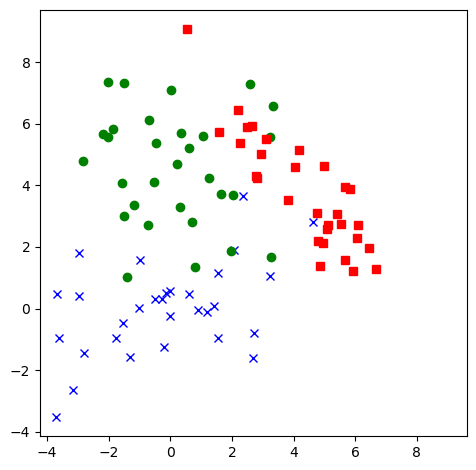

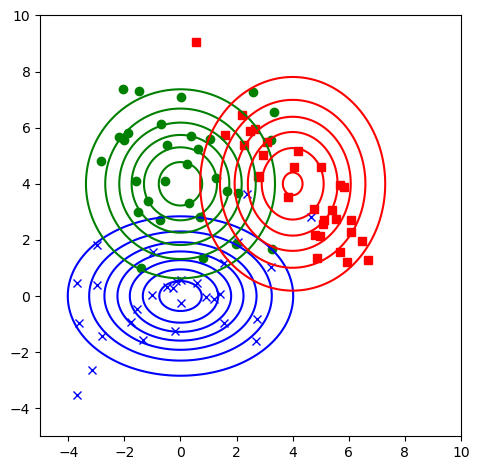

In [149]:
x, labels = make_data(mus, sigmas, n_samples_per_class = 30, seed = 0)
xx, yy, x_range, y_range = make_grid(x)
X = np.vstack(x)
Y = np.hstack(labels)

plt.figure()
plot_points(x)
plt.axis("square")
plt.tight_layout()
savefig("gda_2d_data.pdf")
plt.show()

plt.figure()
plot_points(x)
plot_contours(xx, yy, x_range, y_range, mus, sigmas)
plt.axis("square")
plt.tight_layout()
savefig("gda_2d_contours.pdf")
plt.show()

### Making test data

**Set the random seed for creating test data as AB.**

In [150]:
x_test, labels_test = make_data(mus, sigmas, n_samples_per_class=100, seed=13)
X_test = np.vstack(x_test)
Y_test = np.hstack(labels_test)

## Code for model fitting and plotting

In [151]:
def fit_and_plot(clf, name, mus, sigmas):
    clf.fit(X, Y)

    y_pred = clf.predict(X_test)
    acc = accuracy_score(Y_test, y_pred)
    print("Test accuracy: ", acc)

    z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(ngrid, ngrid)
    z_p = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    yhat = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Yhat = make_one_hot(yhat)


    plt.figure()
    plot_dboundaries(xx, yy, z, Yhat)
    plot_points(x_test)
    plot_contours(xx, yy, x_range, y_range, mus, sigmas)
    plt.title(name)
    plt.axis("square")
    plt.tight_layout()
    savefig("gda_2d_{}.pdf".format(name))
    plt.show()

## Linear Discriminant Analysis (LDA)

In [152]:
def estimate_mvn_tied(X, Y):
    classes = np.unique(Y)
    nclasses = len(classes)
    Sigma = np.cov(X, rowvar=False) # rowvar=False: each column represents a variable, while the rows contain observations.
    sigmas = [Sigma] * nclasses
    mus = []
    for c in classes:
        ndx = Y == c
        Xc = X[ndx]
        mu_c = np.mean(Xc, axis=0)
        mus.append(mu_c)
    return mus, sigmas

mus_tied, sigmas_tied = estimate_mvn_tied(X, Y)

Test accuracy:  0.8466666666666667


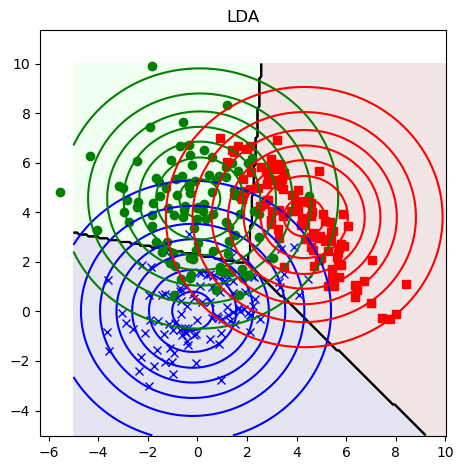

In [153]:
fit_and_plot(LDA(), "LDA", mus_tied, sigmas_tied)

## Gaussian Naive Bayes Classifier

In [154]:
def estimate_mvns_diag(X, Y):
    classes = np.unique(Y)
    mus = []
    sigmas = []
    for c in classes:
        # Select the samples of class c
        X_c = X[Y == c]
        
        # Estimate the mean vector of class c
        mu_c = np.mean(X_c, axis=0)
        mus.append(mu_c)
        
        # Estimate the covariance matrix of class c
        # Note: the Naive Bayes assumptions imply that the covariance matrix is diagonal
        # Therefore, we compute the variance of each feature independently
        Sigma_c = np.diag(np.var(X_c, axis=0))
        sigmas.append(Sigma_c)
    
    return mus, sigmas

mus_est_diag, sigmas_est_diag = estimate_mvns_diag(X, Y)

Test accuracy:  0.8566666666666667


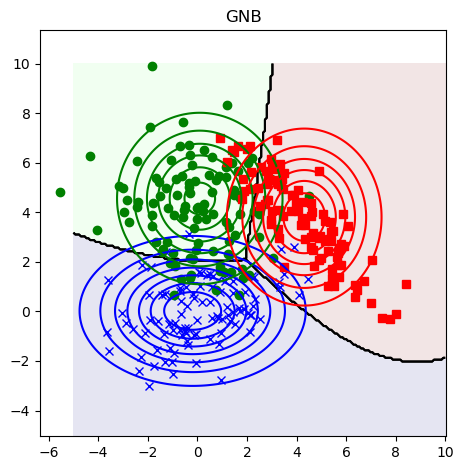

In [155]:
fit_and_plot(GaussianNB(), "GNB", mus_est_diag, sigmas_est_diag)

## Quadratic Discriminant Analysis (QDA)

In [156]:
def estimate_mvns(X, Y):
    classes = np.unique(Y)
    mus = []
    sigmas = []
    for c in classes:
        # Estimate the mean vector of each class
        mu_c = np.mean(X[Y == c], axis=0)
        mus.append(mu_c)

        # Estimate the covariance matrix of each class (Note: the QDA assumptions)
        Sigma_c = np.cov(X[Y == c], rowvar=False)
        sigmas.append(Sigma_c)
    return mus, sigmas

mus_est, sigmas_est = estimate_mvns(X, Y)

Test accuracy:  0.9


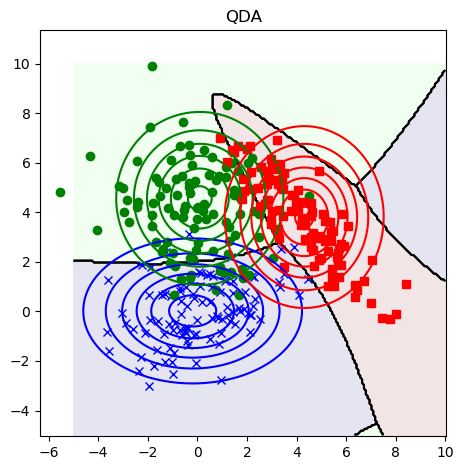

In [157]:
fit_and_plot(QDA(), "QDA", mus_est, sigmas_est)

## Compare Gaussian Naive Bayes, LDA, and QDA.

Write your comments here!

- Gaussian Naive Bayes (GNB): GNB là một thuật toán phân loại dựa trên xác suất. Nó giả định rằng các đặc trưng đều độc lập với nhau. Mặc dù giả định này không thực sự chính xác trong nhiều trường hợp thực tế, GNB vẫn hoạt động tốt trong nhiều tình huống, đặc biệt là khi kích thước tập dữ liệu lớn.

- Linear Discriminant Analysis (LDA): LDA cố gắng tìm ra một ranh giới tuyến tính giữa các lớp để phân loại. LDA giả định rằng tất cả các lớp đều chia sẻ một ma trận hiệp phương sai chung. LDA hoạt động tốt khi các lớp có thể được phân tách bằng một đường thẳng (hoặc một mặt phẳng trong không gian nhiều chiều).

- Quadratic Discriminant Analysis (QDA): QDA tương tự như LDA, nhưng không giả định tất cả các lớp đều chia sẻ một ma trận hiệp phương sai chung. Thay vào đó, mỗi lớp có ma trận hiệp phương sai riêng. Điều này cho phép QDA tạo ra ranh giới phân loại phức tạp hơn (không chỉ là tuyến tính), nhưng cũng có thể dẫn đến overfitting nếu kích thước tập dữ liệu nhỏ.

- Không có thuật toán nào tốt nhất cho mọi tình huống. Lựa chọn thuật toán phù hợp phụ thuộc vào nhiều yếu tố, bao gồm kích thước và tính chất của dữ liệu, cũng như yêu cầu về độ chính xác và độ phức tạp của mô hình.